## Neural Networks for Classification of Emotions

- CNN을 통해 사람의 얼굴의 특징을 추출하고 예측하여 현재 사람의 감정을 추측 할 수 있다.
- 감정 종류: 분노, 기쁨, 분노, 공포, 기본
- 활용 분야: AI비서, 거짓말 탐지, 졸음운전 방지, 온라인 강의 관심도 체크 등등


In [37]:
import cv2
import numpy as np
import os
import zipfile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow .keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns # 데이터 시각화
import matplotlib.pyplot as plt # 그래프 생성
tf.__version__

'2.15.0'

### Loading the Images
- zip 파일 내부 구조 살펴보기
  - fer2013
    - trian: 학습 이미지
    - validation: 검증 이미지
    - README : 안내서
    - fer2013.bib : 데이터 셋의 작가, 정보, 출처 등
    - fer2013.csv: 학습 이미지를 이용하여 추출한 특징들을 따로 csv로 저장해둠 -> 굳이 처음부터 이미지를 학습 시킬 필요는 없음

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file= path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

### Train and test set 불러오기

In [38]:
training_generator = ImageDataGenerator(rescale= 1./255,
                                        rotation_range=7,
                                        horizontal_flip =True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/fer2013/train',
                                                       target_size = (48, 48),
                                                       batch_size = 16,
                                                       class_mode ='categorical',
                                                       shuffle = True)

Found 28709 images belonging to 7 classes.


In [39]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [40]:
# retrun_counts = true이면 각각의 도메인 값의 개수도 알려준다.
np.unique(train_dataset.classes,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [41]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

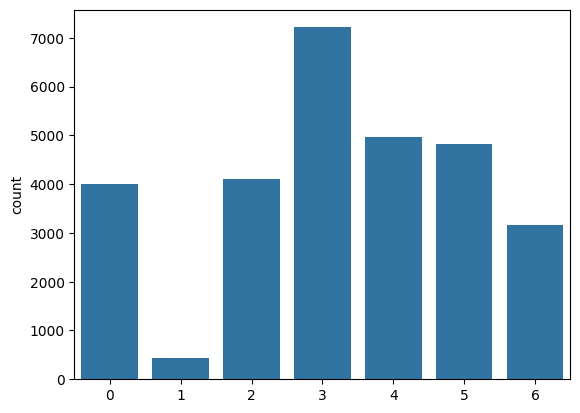

In [42]:
sns.countplot(x=train_dataset.classes);

In [43]:
test_generator = ImageDataGenerator(1./255)
test_dataset = test_generator.flow_from_directory('/content/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size =1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


### 신경망 모델 구축

In [44]:
num_detectors = 32
num_classes = 7
# 학습에 사용될 이미지 크기(48,48,3) 흑백 이미지인데도 채널이 3개인 이유는 3개다 동일한 값을 갖기때문이다.
width, height =48,48
epochs = 100

network = Sequential()

#커널의 수는 num_detectors개 필터 size는 (3,3)
#padding은 same과 valid가 있다
# same은 윈도우 슬라이딩을 하다가 만약 남은 원본이미지의 크기가 필터보다 작다면 0픽셀을 추가하여 합성곱을 하는것이다.
# valid는 초과되는 픽셀은 그냥 버린다 -> 특성이 버려진다.
network.add(Conv2D(num_detectors,(3,3),activation='relu',padding ='same',input_shape = (width, height, 3)))
# 배치 정규화는 각각의 배치들을 한번에 학습시킬때도 배치들 마다 크기가 달라서 학습률도 달라진다.
# 따라서 정규화를 통해 배치들간의 크기를 상대적으로 변환하여 학습을 유리하게 할 수 있다.
network.add(BatchNormalization())
network.add(Conv2D(num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))


network.add(Conv2D(2*num_detectors,(3,3),activation='relu',padding ='same'))
# 배치 정규화는 복잡한 이미지에 적합하다.
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))


network.add(Conv2D(2*2*num_detectors,(3,3),activation='relu',padding ='same'))
# 배치 정규화는 복잡한 이미지에 적합하다.
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))


network.add(Conv2D(2*2*2*num_detectors,(3,3),activation='relu',padding ='same'))
# 배치 정규화는 복잡한 이미지에 적합하다.
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

# flatten으로 필터의 가로크기 * 세로크기 * 커널의 수하면 평탄화 후 출력되는 크기가 나온다.
network.add(Flatten())

network.add(Dense(2*num_detectors, activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

# 무조건 은닉층의 개수 구하는 공식을 쓰는것이아니라 최적의 수를 찾아야한다.
network.add(Dense(2*num_detectors, activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation = 'softmax'))
network.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_28 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_29 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                      

In [45]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
network.fit(train_dataset, epochs=epochs)

Epoch 1/100


KeyboardInterrupt: 

### 신경망 저장 및 불러오기
- 학습이 오래걸리기 때문에 이전에 학습된 가중치 파일을 사용한다.

In [ ]:
# 신경망 구조 저장
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
# 가중치 저장
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [46]:
# 신경망 구조 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [47]:
# 신경망 가중치 불러오기 및 compile설정
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/weights_emotions.hdf5')
network_loaded.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [48]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

### 신경망 평가

In [49]:
# evaluate(test 데이터)는 정확도 평가를 한번에 해주는 함수이다.
# 정확도가 0.58로 생각 보다 낮은데 애초에 감정을 찾는 인공지능은 최신기술로해도 70%정도의 확률로 어려운 주제이기 때문이다.
network_loaded.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


3589/3589 [==============================] - 52s 14ms/step - loss: 257.3426 - accuracy: 0.1513


[257.3425598144531, 0.15129563212394714]

In [50]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 [==============================] - 43s 12ms/step


array([[4.4057932e-10, 1.9942944e-34, 1.0000000e+00, ..., 0.0000000e+00,
        4.1301682e-18, 0.0000000e+00],
       [7.9232240e-01, 0.0000000e+00, 2.0767757e-01, ..., 0.0000000e+00,
        1.0577590e-32, 0.0000000e+00],
       [1.4584910e-13, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        2.9952321e-25, 0.0000000e+00],
       ...,
       [9.9920279e-01, 0.0000000e+00, 7.9720421e-04, ..., 0.0000000e+00,
        1.6168185e-31, 0.0000000e+00],
       [4.1687411e-19, 0.0000000e+00, 1.0000000e+00, ..., 5.6410617e-37,
        1.8266866e-17, 0.0000000e+00],
       [4.1892312e-09, 7.2009567e-35, 1.0000000e+00, ..., 0.0000000e+00,
        2.2603601e-13, 0.0000000e+00]], dtype=float32)

In [51]:
predictions = np.argmax(predictions,axis=1)
predictions

array([2, 0, 2, ..., 0, 2, 2])

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.15129562552242964

In [53]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[105,   0, 377,   0,   0,   9,   0],
       [ 10,   0,  45,   0,   0,   0,   0],
       [ 96,   0, 430,   0,   0,   2,   0],
       [309,   0, 556,   0,   0,  14,   0],
       [131,   0, 484,   0,   0,  11,   0],
       [ 95,   0, 491,   0,   0,   8,   0],
       [ 35,   0, 381,   0,   0,   0,   0]])

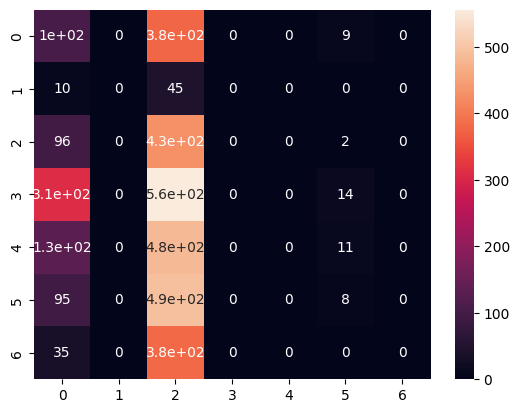

In [55]:
sns.heatmap(cm, annot=True);

In [56]:
from sklearn.metrics import classification_report
# precision, recall(재현률), f1-score(F1점수) 등등을 계산해준다
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.13      0.21      0.17       491
           1       0.00      0.00      0.00        55
           2       0.16      0.81      0.26       528
           3       0.00      0.00      0.00       879
           4       0.00      0.00      0.00       626
           5       0.18      0.01      0.03       594
           6       0.00      0.00      0.00       416

    accuracy                           0.15      3589
   macro avg       0.07      0.15      0.06      3589
weighted avg       0.07      0.15      0.07      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 하나의 단일 이미지 클래스 분류하기
- 실제 사람 이미지를 불러와 감정을 분류해보자
  - 얼굴을 탐지하고 모델의 input에 맞춰 전처리를 해주자